In [1]:
import pandas as pd
import xmltodict
import requests
import os

#### 앱스토어 리뷰 수집하기  
* mostrecent_df 변수: 가장 최근 순으로 정렬  
* mosthelpful_df 변수: 가장 도움이 되는 순으로 정렬  
* review_df 변수 : mostrecent_df + mosthelpful_df - (중복)

In [50]:
def get_url_index(url):
    response = requests.get(url).content.decode('utf8')
    xml = xmltodict.parse(response)

    last_url = [l['@href'] for l in xml['feed']['link'] if (l['@rel'] == 'last')][0]
    last_index = [int(s.replace('page=', '')) for s in last_url.split('/') if ('page=' in s)][0]

    return last_index

# https://stackoverflow.com/questions/1090282/api-to-monitor-iphone-app-store-reviews
def appstore_crawler(appid,sortmethod):
    url = 'https://itunes.apple.com/kr/rss/customerreviews/page=1/id=%i/sortby=%s/xml' % (appid, sortmethod)
    try:
        last_index = get_url_index(url)
    except Exception as e:
        print (url)
        print ('\tNo Reviews: appid %i' %appid)
        print ('\tException:', e)
        return

    result = list()
    for idx in range(1, last_index+1):
        url = "https://itunes.apple.com/kr/rss/customerreviews/page=%i/id=%i/sortby=%s/xml?urlDesc=/customerreviews/id=%i/sortBy=%s/xml" % (idx, appid, sortmethod, appid, sortmethod)
        print(url)

        response = requests.get(url).content.decode('utf8')
        try:
            xml = xmltodict.parse(response)
        except Exception as e:
            print ('\tXml Parse Error %s\n\tSkip %s :' %(e, url))
            continue

        try:
            num_reivews= len(xml['feed']['entry'])
        except Exception as e:
            print ('\tNo Entry', e)
            continue

        try:
            xml['feed']['entry'][0]['author']['name']
            single_reviews = False
        except:
            #print ('\tOnly 1 review!!!')
            single_reviews = True
            pass

        if single_reviews:
                result.append({
                    'userName': xml['feed']['entry']['author']['name'],
                    'date': xml['feed']['entry']['updated'],
                    'rating': int(xml['feed']['entry']['im:rating']),
                    'like': int(xml['feed']['entry']['im:voteSum']),
                    'title': xml['feed']['entry']['title'],
                    'review': xml['feed']['entry']['content'][0]['#text'],
                })
        else:
            for i in range(len(xml['feed']['entry'])):
                result.append({
                    'userName': xml['feed']['entry'][i]['author']['name'],
                    'date': xml['feed']['entry'][i]['updated'],
                    'rating': int(xml['feed']['entry'][i]['im:rating']),
                    'like': int(xml['feed']['entry'][i]['im:voteSum']),
                    'title': xml['feed']['entry'][i]['title'],
                    'review': xml['feed']['entry'][i]['content'][0]['#text'],
                })

    res_df = pd.DataFrame(result)
    res_df['date'] = pd.to_datetime(res_df['date'], format="%Y-%m-%dT%H:%M:%S")
#     res_df.to_csv(outfile, encoding='utf-8-sig', index=False)
#     print ('Save reviews to file: %s \n' %(outfile))
    return res_df


if __name__ == '__main__':
    app_id = 993504342
    mostrecent_df = appstore_crawler(app_id, 'mostrecent')
    mosthelpful_df = appstore_crawler(app_id, 'mosthelpful')
    
    # 병합
    review_df = pd.concat([mostrecent_df, mosthelpful_df])
    review_df.drop_duplicates(keep="first",inplace=True)
    review_df['content'] = review_df['title'] + ' ' + review_df['review']

https://itunes.apple.com/kr/rss/customerreviews/page=1/id=993504342/sortby=mostrecent/xml?urlDesc=/customerreviews/id=993504342/sortBy=mostrecent/xml
https://itunes.apple.com/kr/rss/customerreviews/page=2/id=993504342/sortby=mostrecent/xml?urlDesc=/customerreviews/id=993504342/sortBy=mostrecent/xml
https://itunes.apple.com/kr/rss/customerreviews/page=3/id=993504342/sortby=mostrecent/xml?urlDesc=/customerreviews/id=993504342/sortBy=mostrecent/xml
https://itunes.apple.com/kr/rss/customerreviews/page=4/id=993504342/sortby=mostrecent/xml?urlDesc=/customerreviews/id=993504342/sortBy=mostrecent/xml
https://itunes.apple.com/kr/rss/customerreviews/page=5/id=993504342/sortby=mostrecent/xml?urlDesc=/customerreviews/id=993504342/sortBy=mostrecent/xml
https://itunes.apple.com/kr/rss/customerreviews/page=6/id=993504342/sortby=mostrecent/xml?urlDesc=/customerreviews/id=993504342/sortBy=mostrecent/xml
https://itunes.apple.com/kr/rss/customerreviews/page=7/id=993504342/sortby=mostrecent/xml?urlDesc=/c

In [52]:
# 파일 저장
review_df.to_csv("./crawling_data/apple_thinq_original.csv",encoding='utf-8 sig', index=False)

---------------------------------

In [54]:
# 파일 불러오기
review_df = pd.read_csv("./crawling_data/apple_thinq_original.csv", encoding='utf-8 sig')
review_df

,userName,date,rating,like,title,review,content
0,강남오렌지,2022-07-24 20:24:44-07:00,1,0,스마트케어 온도 설정,"기준 온도 직접 설정 27도로 설정해놨는데, 자꾸 희망온도가 28도로 올라감...하..","스마트케어 온도 설정 기준 온도 직접 설정 27도로 설정해놨는데, 자꾸 희망온도가 ..."
1,우주괴에물,2022-07-24 08:08:11-07:00,1,0,TV 연결 안됨,유튜브나 넷플릭스에서는 같은 네트워크일 때 연결하겠습니까 잘 뜨는데 씽큐에서 제품연...,TV 연결 안됨 유튜브나 넷플릭스에서는 같은 네트워크일 때 연결하겠습니까 잘 뜨는데...
2,ㅇ헣ㄹㅇ,2022-07-24 05:57:38-07:00,5,0,굿,엘지 iot 시작,굿 엘지 iot 시작
3,까암씨,2022-07-23 22:59:15-07:00,5,0,건조기 등록이 너무 어려워 별 4 개요,건조기 등록이 너무 잘안되용. 그래서 4 개 입니다.,건조기 등록이 너무 어려워 별 4 개요 건조기 등록이 너무 잘안되용. 그래서 4 개...
4,라이프이즈구웃,2022-07-23 07:35:17-07:00,4,0,백색가전은 엘지,앱으로 가전 제품 관리하기가 용이해요,백색가전은 엘지 앱으로 가전 제품 관리하기가 용이해요
...,...,...,...,...,...,...,...
913,ㅎㅎㅋㅋㅎㅎㄹㅋㄱㅁ,2019-06-22 04:15:25-07:00,3,0,우와 했는데,오늘 에어컨 설치하고 어플받고 제품등록 싹하고 기존에 있던 공기청정기 등록 다하고 ...,우와 했는데 오늘 에어컨 설치하고 어플받고 제품등록 싹하고 기존에 있던 공기청정기 ...
914,샤레레마,2018-04-26 16:36:23-07:00,5,0,관리를 안하는건가요?,원격제품은 팔아놓으시고 서비스관리는 안하시는 건가요? 저번에도 그랬는데 어제부터 서...,관리를 안하는건가요? 원격제품은 팔아놓으시고 서비스관리는 안하시는 건가요? 저번에도...
915,Myoyu,2021-08-28 16:29:22-07:00,2,0,업데이트후 제습기 예약 동작 오류,"매일, 일정시간에 켜고 일정시간후 끄기 예약 기능 잘 사용하고 있었는데 업데이트후 ...","업데이트후 제습기 예약 동작 오류 매일, 일정시간에 켜고 일정시간후 끄기 예약 기능..."
916,초등학생,2021-08-22 00:19:29-07:00,3,0,에어컨 네트워크 보안 WPA3 지원요청,에어컨 네트워크 보안 WAP3 지원 요청합니다.\n\n현재는 지원을 안해서 WPA/...,에어컨 네트워크 보안 WPA3 지원요청 에어컨 네트워크 보안 WAP3 지원 요청합니...


####  데이터 전처리  
- 문장 자르기
- 맞춤법 검사  
- 품사 분류  
- 불용어 처리  

In [55]:
# 문자 빼고 지움(정규표현식)
# 문장 자르기
import kss
import re

UNKNOWN_WORD = "...하"
def OnlyWords(s):
    result = re.sub('[^ A-Za-z가-힣]', '', s)
    return result

review_df['content_n']=review_df['content'].apply(\
        lambda x: kss.split_sentences(OnlyWords(x)) if UNKNOWN_WORD not in x else kss.split_sentences(OnlyWords(x).replace(UNKNOWN_WORD,"..")))

[Korean Sentence Splitter]: Initializing Pynori...


In [56]:
# 맞춤법 검사 
from hanspell import spell_checker

def spell_checking(sent_list):
    sent_spell=[]
    for sentence in sent_list:
        sent_spell.append(spell_checker.check(sentence).checked)
    return(sent_spell)

review_df['cotent_n_spell']=review_df['content_n'].apply(lambda x: spell_checking(x))

In [57]:
# 중간 저장
review_df.to_csv("./crawling_data/apple_thinq_preprocessing1.csv", encoding='utf-8 sig', index=False)

In [58]:
review_df['content_n']=review_df['cotent_n_spell']

In [59]:
from konlpy.tag import Okt  
okt=Okt() 
# 명사, 형용사, 동사
def n_a_v_selection(sent_list):
    sent_tokens=[]
    for sentence in sent_list:
        pos_result=okt.pos(sentence, stem=True)
        filtered_result=[pair[0] for pair in pos_result if (pair[1]=='Alpha')or(pair[1]=='Noun')or(pair[1]=='Verb')or(pair[1]=='Adjective') or(pair[1]=='Adverb')]
        sent_tokens.append(filtered_result)
    return sent_tokens

# 명사, 형용사
def n_a_selection(sent_list):
    sent_tokens=[]
    for sentence in sent_list:
        pos_result=okt.pos(sentence, stem=True)
        filtered_result=[pair[0] for pair in pos_result if (pair[1]=='Alpha')or(pair[1]=='Noun')or(pair[1]=='Adjective') or(pair[1]=='Adverb')]
        sent_tokens.append(filtered_result)
    return sent_tokens
        
# 명사만
def noun_selection(sent_list):
    sent_tokens=[]
    for sentence in sent_list:
        sent_tokens.append(okt.nouns(sentence))
    return(sent_tokens)


review_df['content_n']=review_df['content_n'].apply(lambda x: n_a_v_selection(x))

In [60]:
# 불용어 처리
import json

with open('korean_stopword.json',encoding='utf8') as f:
    stopwords = json.load(f)

stopwords.extend(['안','수','거','왜','것','후','에서','고','이다','는','한','안녕','형','형님','건','안','요','거','피','질','번','용','군','영','스','좀','데','듯','넉','테','런','하다','하나요','되다','안되다','있다','없다'])

def rem_n_stopwords(sent_list):
    sent_stop=[]
    for sentence in sent_list:
        new_sent=[]
        for token in sentence:
            if token not in stopwords:
                new_sent.append(token)
        sent_stop.append(new_sent)
    return(sent_stop)

review_df['content_n']=review_df['content_n'].apply(lambda x: rem_n_stopwords(x))

In [61]:
# 빈 리스트 제거
def remove_empty_list(sent_list):
    removed_list = []
    for sentence in sent_list:
        if sentence: # sentence가 빈 경우가 아니면
            removed_list.append(sentence)    
    return removed_list

review_df['content_n']=review_df['content_n'].apply(lambda x: remove_empty_list(x))

# review_df.to_csv('thinq_review_result.csv',index=False, encoding='utf-8-sig')

# 리뷰 전체를 한 리스트로 만들기
def one_word_list(sent_list):
    one_list=[]
    for sentence in sent_list:
        one_list.extend(sentence)
    return(one_list)

# test['content_n']=test['content_n'].apply(lambda x: one_word_list(x))
review_df['content_n']=review_df['content_n'].apply(lambda x: one_word_list(x))

In [62]:
# 전처리 完
review_df.to_csv("./crawling_data/apple_thinq_processing2_65.csv", encoding='utf-8 sig', index=False)

In [63]:
# 단어 빈도 그래프
total_word=[]
for i in range(len(review_df)):
    total_word.extend(review_df.loc[i,'content_n'])

word_vc = pd.Series(total_word).value_counts()

#### (4) 워드클라우드  
- 워드클라우드 만들고 이미지 저장

In [ ]:
# 프로그램 재실행할 경우, 파일 읽기
review_df = pd.read_csv("./crawling_data/apple_thinq_processing2_65.csv", encoding='utf-8 sig')

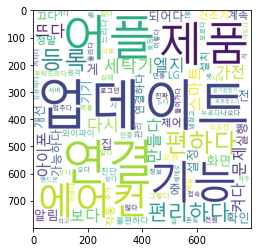

In [70]:
# 워드클라우드
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_dict = word_vc.to_dict()
delete_word = ['앱','더','개','해주다','좋다','사용','자다','않다','너무','아니다','돼다','쓰다','다']
for word in delete_word:
    del word_dict[word]

wc = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf', 
               width=400, height=400,scale=2,
               max_font_size=250, max_words=100,
               background_color='white')
gen = wc.generate_from_frequencies(word_dict)
plt.figure()
plt.imshow(gen)
# plt.savefig("./crawling_data/gps_thinq_65_n_wordcloud.png")

In [71]:
# 이미지 저장
plt.savefig("./crawling_data/apple_thinq_nav_wordcloud.png")

<Figure size 432x288 with 0 Axes>